##  Word embeddings

Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.

1. Using the Skipgram model
2. Using CBOW model
3. Analyze the four different word embeddings
* Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
* Compare the performance on the analogy task between the word embeddings
* Visualize your results and interpret your results
3. Discuss:
* What are the main advantages of CBOW and Skipgram?
* What are the main drawbacks of CBOW and Skipgram?

In [0]:
# import file - just need to choose you local alice.txt file!!!!
from google.colab import files
uploaded = files.upload()

Saving alice.txt to alice (13).txt


In [0]:
# imports
from __future__ import division
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda, Flatten
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from itertools import islice
from matplotlib import pylab
from matplotlib import pyplot as plt
#%matplotlib notebook
plt.style.use('ggplot')

Using TensorFlow backend.


## 1. Data preprocess

In [0]:
# DO NOT Modify the lines in this cell
path = './alice.txt'
corpus = open(path).readlines()

# list of sentences
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
# Updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(corpus)
# text_to_sequences is a mapping of words to unique indexes. Lower index means more common words (for instance, index 0 is 'the')
corpus = tokenizer.texts_to_sequences(corpus)

# samples = number of words in the text 
nb_samples = sum(len(s) for s in corpus)

# V = number of unique words in the text
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100   # embedding vector length (hidden layer): 50, 150, 300
window_size = 2
window_size_corpus = 4
epochs = 20

## 2. Skipgram

In [0]:
#prepare data for skipgram
def generate_data_skipgram(corpus, window_size, V):
    #TODO Implement here
    maxlen = window_size*2
    all_in = []
    all_out = []
    # words represents sentence
    for words in corpus:
        # number of words per sentence
        L = len(words)
        for index, word in enumerate(words):
          
            # p and n boundary indexes of [wt-2, ..., wt+2]
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Add the input word
                    all_in.append(word)
                    # Add one of the context words
                    all_out.append(np_utils.to_categorical(words[i], V))
                                                    
    return (np.array(all_in),np.array(all_out))

In [0]:
#training data
x_skip, y_skip = generate_data_skipgram(corpus,window_size,V)

In [0]:
#create Skipgram model

#TODO Skipgram keras implementation
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
skipgram.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 100)            255700    
_________________________________________________________________
reshape_1 (Reshape)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2557)              258257    
Total params: 513,957
Trainable params: 513,957
Non-trainable params: 0
_________________________________________________________________


In [0]:
#train Skipgram model
%%time
history_skip = skipgram.fit(x_skip, y_skip, batch_size=128, epochs=epochs, verbose=1, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 75644 samples, validate on 18912 samples
Epoch 1/20
75644/75644 [==============================] - 3s 46us/step - loss: 7.5714 - val_loss: 7.1469
Epoch 2/20
75644/75644 [==============================] - 2s 31us/step - loss: 6.7696 - val_loss: 6.5808
Epoch 3/20
75644/75644 [==============================] - 2s 32us/step - loss: 6.3275 - val_loss: 6.3405
Epoch 4/20
75644/75644 [==============================] - 2s 31us/step - loss: 6.1208 - val_loss: 6.2220
Epoch 5/20
75644/75644 [==============================] - 2s 31us/step - loss: 6.0009 - val_loss: 6.1503
Epoch 6/20
75644/75644 [==============================] - 2s 32us/step - loss: 5.9194 - val_loss: 6.0997
Epoch 7/20
75644/75644 [==============================] - 2s 32us/step - loss: 5.8594 - val_loss: 6.0619
Epoch 8/20
75644/75644 [==============================] - 2s 31us/step - loss: 5.8119 - val_loss: 6.0358
Epoch 9/20
75644/75644 [==============================] - 2s 3

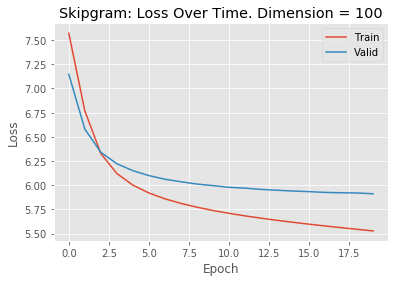

In [0]:
% matplotlib inline

plt.plot(history_skip.history['loss'])
plt.plot(history_skip.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Skipgram: Loss Over Time. Dimension = %d' % dim)
plt.legend(['Train','Valid'])

## 3. CBOW

In [0]:
#prepare data for CBOW
def generate_data_cbow(corpus, window_size, V):
    #TODO Implement here
    maxlen = window_size*2
    all_in = []
    all_out = []
    # words represents sentence
    for words in corpus:
        # number of words per sentence
        L = len(words)
        for index, word in enumerate(words):
          
            # p and n boundary indexes of [wt-2, ..., wt+2]
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Add one of the context words
                    in_words.append(words[i])
            
            labels.append(word)     

            all_in.append(sequence.pad_sequences([in_words], maxlen=maxlen))
            all_out.append(np_utils.to_categorical(labels, V))
    
    all_in = [item for sublist in all_in for item in sublist]
    all_out = [item for sublist in all_out for item in sublist]

    return (np.array(all_in),np.array(all_out))

In [0]:
#training data
x_cbow, y_cbow = generate_data_cbow(corpus,window_size,V)

In [0]:
#create CBOW model

#TODO CBOW keras implementation
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size_corpus))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(units=V, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [0]:
cbow.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 100)            255700    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2557)              258257    
Total params: 513,957
Trainable params: 513,957
Non-trainable params: 0
_________________________________________________________________


In [0]:
#train CBOW model
%%time
history_cbow = cbow.fit(x_cbow, y_cbow, batch_size=128, epochs=epochs, verbose=1, validation_split = 0.2)

Train on 21732 samples, validate on 5433 samples
Epoch 1/20
21732/21732 [==============================] - 1s 41us/step - loss: 7.7764 - val_loss: 7.6884
Epoch 2/20
21732/21732 [==============================] - 1s 33us/step - loss: 7.4631 - val_loss: 7.1910
Epoch 3/20
21732/21732 [==============================] - 1s 33us/step - loss: 6.9992 - val_loss: 6.8648
Epoch 4/20
21732/21732 [==============================] - 1s 33us/step - loss: 6.6878 - val_loss: 6.6417
Epoch 5/20
21732/21732 [==============================] - 1s 33us/step - loss: 6.4804 - val_loss: 6.5049
Epoch 6/20
21732/21732 [==============================] - 1s 33us/step - loss: 6.3484 - val_loss: 6.4050
Epoch 7/20
21732/21732 [==============================] - 1s 33us/step - loss: 6.2513 - val_loss: 6.3239
Epoch 8/20
21732/21732 [==============================] - 1s 33us/step - loss: 6.1734 - val_loss: 6.2601
Epoch 9/20
21732/21732 [==============================] - 1s 34us/step - loss: 6.1071 - val_loss: 6.2066
Epoch 

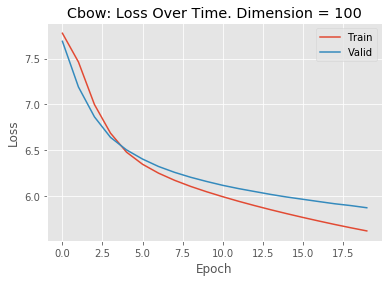

In [0]:
% matplotlib inline

plt.plot(history_cbow.history['loss'])
plt.plot(history_cbow.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cbow: Loss Over Time. Dimension = %d' % dim)
plt.legend(['Train','Valid'])


## 4. Analyze the different word embeddings

In [0]:
#Implement your own analogy function
def embed(word, embedding, tokenizer=tokenizer):
    # get the index of the word from the tokenizer
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the size of the dictionary from the embedding matrix
    dict_size = embedding.shape[0]
    # get the one-hot encoding of the word
    bin_word = np_utils.to_categorical(int_word, dict_size)
    return np.dot(bin_word, embedding)

### Comparison performance:

In [0]:
# Get the embedding matrix and weights
weights_skipgram = skipgram.get_weights()
embedding_skipgram = weights_skipgram[0]

weights_cbow= cbow.get_weights()
embedding_cbow = weights_cbow[0]

In the following example we compare the word representation of 'Queen' with the analog word representation of 'King' - 'Man' - 'Woman'. If this analog relationship is true, the distance should be low. We compute this distance with the two models. So, the lower the distance the better the model captures this analogy relationship.

In [0]:
# Skipgram
queen_skip = embed('king', embedding_skipgram) - embed('man', embedding_skipgram) + embed('woman', embedding_skipgram)
dist_skip = np.linalg.norm(queen_skip - embed('queen', embedding_skipgram))
print('Queen relation - Queen embedded distance Skipgram: ', dist_skip)

# Cbow
queen_cbow = embed('king', embedding_cbow) - embed('man', embedding_cbow) + embed('woman', embedding_cbow)
dist_cbow = np.linalg.norm(queen_cbow - embed('queen', embedding_cbow))
print('Queen relation - Queen embedded distance Cbow: ', dist_cbow)


Queen relation - Queen embedded distance Skipgram:  1.2124484
Queen relation - Queen embedded distance Cbow:  1.2999518


In the following example, we want to prove if it's true the statement 'A king is to a queen as a man is to a woman'. To do so, we compute the distance between king-queen and man-woman with the two models. In this case, the more similar is one distance to the other (dist_king - dist_gender), the more true is the original statement.

In [0]:
#vking - vqueen = vman - vwoman

#Skipgram
dist_kings_skipgram = np.linalg.norm(embed('king', embedding_skipgram) - embed('queen', embedding_skipgram))
dist_gender_skipgram = np.linalg.norm(embed('man', embedding_skipgram) - embed('woman', embedding_skipgram))

print('Kings distance Skipgram: ', dist_kings_skipgram)
print('Gender distance Skipgram: ', dist_gender_skipgram)

#Cbow
dist_kings_cbow = np.linalg.norm(embed('king', embedding_cbow) - embed('queen', embedding_cbow))
dist_gender_cbow = np.linalg.norm(embed('man', embedding_cbow) - embed('woman', embedding_cbow))

print('\nKings distance Cbow: ', dist_kings_cbow)
print('Gender distance Cbow: ', dist_gender_cbow)

Kings distance Skipgram:  1.072982
Gender distance Skipgram:  0.47862595

Kings distance Cbow:  1.1330097
Gender distance Cbow:  0.4238764


## 5. Visualization results

Comparison of execution time between the two models. As it is shown, CBOW requires way less computing time than Skipgram.


*   **dimension = 50**
     Skipgram: 1m3s. CBOW: 19.8 s
*     **dimension = 150**
     Skipgram: 1m4s. CBOW: 19.7 s
*   **dimension = 300**
     Skipgram: 1m11s. CBOW: 22.1s




Below, are shown further experiments of section 18 with different hidden layer dimension. We observed that with dimension 100 the representation of the words are quite similar between the two models and since, CBOW requires less computing time, is more convenient.

1. **DIM=50**
* Queen relation - Queen embedded distance Skipgram:  0.9363213. 
* Queen relation - Queen  embedded distance Cbow:  1.4699881

---------
2. **DIM = 100**
* Queen relation - Queen embedded distance Skipgram:  1.2124484. 
* Queen relation - Queen embedded distance Cbow:  1.2999518


-------------
3. **DIM = 150**
* Queen relation - Queen embedded distance Skipgram:  1.3386092. 
* Queen relation -  Queen embedded distance Cbow:  1.1798261

-------
4. **DIM = 300**
* Queen relation - Queen embedded distance Skipgram:  1.7997762. 
* Queen relation - Queen embedded distance Cbow:  1.320562



In the following [link](https://drive.google.com/open?id=1GIlN5lgBfnjkDfW2xVw3Y3fpmOaZm2bD) they can be observed the different loss function curves when training the models with different hidden layer dimension size.

## 6. Interpretation results of the visualization

**Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram**

**Advantages and disadvantages of CBOW**
1.	The training time in CBOW is much less than skip-gram as showed above.
2.	It has better accuracy for frequent words as illustrated in the results.

**Advantages and disadvantages of Skip-gram**
1.	It works well for smaller training data size.
2.	It represents rare words in the dataset better than CBOW.

**Advantages of Negative Sampling**

Negative sampling is useful for improving the performance time of the training a neural network. For a dataset with 100 words and a network with 100 components, a weight matrix of 100 * 100 dimensions will be generated where each of the weights is updated making it time consuming. Negative sampling solves it by having each training sample update a small percentage of the weights rather than all of them. A small number of samples are selected as negative words for one target word randomly and their weights updated. And here, negative words mean the words for which the model output should be 0. In the hidden layer, always the weights of the input words are updated. So, finally for the output layer, the update has been done only for the positive word and and the weights of randomly selected negative words to get output 0. 